# Library

In [14]:
import os
import logging
import json

import pandas as pd
import numpy as np

from PIL import Image, ImageDraw

from datasets import load_dataset, Dataset

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
from transformers import AutoImageProcessor, AutoProcessor, AutoModelForZeroShotObjectDetection, TrainingArguments, Trainer, pipeline

import torch
import albumentations

from torchmetrics.detection import MeanAveragePrecision

from HungarianMatcher import HungarianMatcher
from SetCriterion import SetCriterion
from CustomTrainer import CustomTrainer

In [5]:
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Logging

In [6]:
# Configure logging (example for `logging` module)
logging.basicConfig(
    level=logging.WARNING,  # Adjust as needed (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

# Data

In [8]:
df2 = pd.read_json('../data/vlm.jsonl', lines=True)
df2.to_json('../data/vlm_use.jsonl', orient='records', lines=True)

lst = list(filter(lambda x: x != None, pd.DataFrame([i for i in list(df2['annotations'].apply(lambda x: [i['caption'] for i in x]))]).to_numpy().flatten()))
categories = list(dict.fromkeys(lst))

id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

text_inputs = list(id2label.values())

In [21]:
cppe5 = load_dataset('ekmi00/vlm-images')
temp = list(map(lambda x: json.loads(str(x).replace("'", '"')), cppe5['train']['objects']))
cppe5['train'] = cppe5['train'].remove_columns('objects')
cppe5['train'] = cppe5['train'].add_column('objects',column=temp)
cppe5['train']

Generating train split: 3000 examples [00:08, 371.87 examples/s]


Dataset({
    features: ['image', 'image_id', 'width', 'height', 'objects'],
    num_rows: 3000
})

In [11]:
cppe5 = cppe5['train'].train_test_split(test_size=0.2)
cppe5

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 80
    })
    test: Dataset({
        features: ['image', 'image_id', 'width', 'height', 'objects'],
        num_rows: 20
    })
})

# Model & Processor

In [12]:
# using image processor from detr
image_processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-50")

checkpoint = "google/owlvit-base-patch32"
processor = AutoProcessor.from_pretrained(checkpoint)

model = AutoModelForZeroShotObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
model.to(device)

print("loaded!")

# other better checkpoints, but would run out of memory with current T4 instance for fine-tuning, could be use for inference
# google/owlv2-base-patch16
# google/owlv2-large-patch14-finetuned
# google/owlv2-base-patch16-ensemble
# while with significant better performance, would run into OOM (Out of memory)

c:\Users\Keck\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Keck\.cache\huggingface\hub\models--google--owlvit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


loaded!


# Encoding

In [15]:
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)


def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

# transforming a batch
def transform_aug_ann(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    transformed_data = []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])
        transformed_data.append(processor(text=text_inputs, images=image, return_tensors="pt"))

    
    return {"transformed_data":transformed_data}

# transforming a batch
def transform_aug_ann_labels(examples):
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["category"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

def collate_fn(batch):
    input_ids = torch.Tensor([item["input_ids"] for item in batch]).int()
    input_ids = input_ids.to(device)
    attention_mask = torch.Tensor([item["attention_mask"] for item in batch]).int()
    attention_mask = attention_mask.to(device)
    pixel_values = torch.Tensor([item["pixel_values"] for item in batch])
    pixel_values = pixel_values.to(device)
    labels = []
    for item in batch:
        for (key, value) in item["labels"].items():
            item["labels"][key] = torch.Tensor(value).to(device)
        labels.append(item["labels"])
     
    batch = {}
    batch["input_ids"] = input_ids
    batch["attention_mask"] = attention_mask
    batch["pixel_values"] = pixel_values
    batch["labels"] = labels
    return batch

In [17]:
#applying to the datasets
transform_1 = cppe5["train"].with_transform(transform_aug_ann)
transform_2 = cppe5["train"].with_transform(transform_aug_ann_labels)

#applying to the datasets
transform_1_test = cppe5["test"].with_transform(transform_aug_ann)
transform_2_test = cppe5["test"].with_transform(transform_aug_ann_labels)

def dataset_prep(transform_1, transform_2):
    data = []
    for i in range(len(transform_1)):
        dict_ = {}
        dict_["input_ids"] = transform_1[i]["transformed_data"]["input_ids"]
        dict_["attention_mask"] = transform_1[i]["transformed_data"]["attention_mask"]
        dict_["pixel_values"] = transform_1[i]["transformed_data"]["pixel_values"][0]
        dict_["labels"] = transform_2[i]["labels"]
        data.append(dict_)

    # Preprocessed Training Data
    x_dataset = Dataset.from_list(data)
    return x_dataset


train_dataset = dataset_prep(transform_1, transform_2)
train_dataset.features

test_dataset = dataset_prep(transform_1_test, transform_2_test)
test_dataset.features

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


{'input_ids': Sequence(feature=Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), length=-1, id=None),
 'pixel_values': Sequence(feature=Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None), length=-1, id=None),
 'labels': {'area': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None),
  'boxes': Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None),
  'class_labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'image_id': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'iscrowd': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'orig_size': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
  'size': Sequence(feature=Value(dtype='int

# Training

To compute the custom loss we defined, we need to create a custom Trainer that inherits from the Hugging Face Trainer class. This will allow us to override the compute_loss method and implement our custom loss calculation.

In [18]:
training_args = TrainingArguments(
    output_dir="owlvit-base-patch32_FT",
    per_device_train_batch_size=1,
    num_train_epochs=3,
    fp16=True,
    save_steps=100,
    logging_steps=50,	
    learning_rate=1e-6, #1e-5
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    dataloader_pin_memory=False,
    gradient_accumulation_steps=1,
    push_to_hub=False,
    report_to='none', # disable wandb
)


# use new trainer
trainer = CustomTrainer(
	model=model,
	args=training_args,
	data_collator=collate_fn,
	train_dataset=train_dataset,
	tokenizer=processor, 
	categories=categories
)
 
eval_dict = trainer.train()

  0%|          | 0/240 [00:00<?, ?it/s]INFO:root:type(outputs)=<class 'transformers.models.owlvit.modeling_owlvit.OwlViTObjectDetectionOutput'>
INFO:root:type(targets)=<class 'list'>
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 56.,  58.,  86.,  47.,  97.,   8.,  23., 108.], device='cuda:0')
INFO:root:forward - tensor([ 56,  58,  86,  47,  97,   8,  23, 108], device='cuda:0',
       dtype=torch.int32)
INFO:root:loss_labels - odict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
  0%|          | 1/240 [00:03<13:52,  3.48s/it]INFO:root:type(outputs)=<class 'transformers.models.owlvit.modeling_owlvit.OwlViTObjectDetectionOutput'>
INFO:root:type(targets)=<class 'list'>
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_mod

{'loss': 181.1228, 'grad_norm': 79.18580627441406, 'learning_rate': 8.166666666666666e-07, 'epoch': 0.62}


INFO:root:type(outputs)=<class 'transformers.models.owlvit.modeling_owlvit.OwlViTObjectDetectionOutput'>
INFO:root:type(targets)=<class 'list'>
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 18.,  34.,  66.,  40., 107.], device='cuda:0')
INFO:root:forward - tensor([ 18,  34,  66,  40, 107], device='cuda:0', dtype=torch.int32)
INFO:root:loss_labels - odict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
 21%|██▏       | 51/240 [00:57<03:22,  1.07s/it]INFO:root:type(outputs)=<class 'transformers.models.owlvit.modeling_owlvit.OwlViTObjectDetectionOutput'>
INFO:root:type(targets)=<class 'list'>
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 46., 122.,  7

{'loss': 6.4004, 'grad_norm': 79.71637725830078, 'learning_rate': 6.083333333333333e-07, 'epoch': 1.25}


INFO:root:type(outputs)=<class 'transformers.models.owlvit.modeling_owlvit.OwlViTObjectDetectionOutput'>
INFO:root:type(targets)=<class 'list'>
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 58.,  67.,  19.,  13., 110.,  50.], device='cuda:0')
INFO:root:forward - tensor([ 58,  67,  19,  13, 110,  50], device='cuda:0', dtype=torch.int32)
INFO:root:loss_labels - odict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
 42%|████▏     | 101/240 [01:53<04:30,  1.94s/it]INFO:root:type(outputs)=<class 'transformers.models.owlvit.modeling_owlvit.OwlViTObjectDetectionOutput'>
INFO:root:type(targets)=<class 'list'>
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 9

{'loss': 6.24, 'grad_norm': 61.8089485168457, 'learning_rate': 4e-07, 'epoch': 1.88}


INFO:root:type(outputs)=<class 'transformers.models.owlvit.modeling_owlvit.OwlViTObjectDetectionOutput'>
INFO:root:type(targets)=<class 'list'>
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 6., 78., 41.], device='cuda:0')
INFO:root:forward - tensor([ 6, 78, 41], device='cuda:0', dtype=torch.int32)
INFO:root:loss_labels - odict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
 63%|██████▎   | 151/240 [02:48<01:35,  1.07s/it]INFO:root:type(outputs)=<class 'transformers.models.owlvit.modeling_owlvit.OwlViTObjectDetectionOutput'>
INFO:root:type(targets)=<class 'list'>
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 46., 122.,  70.], device='cuda:0')
INFO:

{'loss': 5.9936, 'grad_norm': 88.49303436279297, 'learning_rate': 1.9166666666666668e-07, 'epoch': 2.5}


INFO:root:type(outputs)=<class 'transformers.models.owlvit.modeling_owlvit.OwlViTObjectDetectionOutput'>
INFO:root:type(targets)=<class 'list'>
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([14., 77., 52., 35., 39.], device='cuda:0')
INFO:root:forward - tensor([14, 77, 52, 35, 39], device='cuda:0', dtype=torch.int32)
INFO:root:loss_labels - odict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
 84%|████████▍ | 201/240 [03:45<01:15,  1.93s/it]INFO:root:type(outputs)=<class 'transformers.models.owlvit.modeling_owlvit.OwlViTObjectDetectionOutput'>
INFO:root:type(targets)=<class 'list'>
INFO:root:outputs.keys()=dict_keys(['logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])
INFO:root:forward - tensor([ 39.,  50.,  23., 122.,

{'train_runtime': 266.4194, 'train_samples_per_second': 0.901, 'train_steps_per_second': 0.901, 'train_loss': 42.62396748860677, 'epoch': 3.0}


In [19]:
model_path = "local/custom_owl_vit_1"
trainer.save_model(model_path)

# Evaluate
## Prediction

In [20]:
model_path = "local/custom_owl_vit_1"
detector = pipeline(model=model_path, task="zero-shot-object-detection")

finetune_prediction_dict = {}
for idx, i in enumerate(cppe5['test']):
    predictions = detector(
        i["image"],
        candidate_labels=categories,
        threshold=0.10,
        top_k=10
    )
    finetune_prediction_dict[idx] = predictions

In [ ]:
test_dt = cppe5["test"].to_pandas()

## Parser

In [ ]:
def convert_data(data):
  """
  Converts the given dictionary into a list of dictionaries with tensors.
  """

  result = []
  for i in range(len(data)):
    # Extract data for each instance
    # print(data[i])
    box_list = []
    label_list = []
    for j in range(len(data[i]['category'])):
        bbox = data[i]['bbox'][j]
        category = data[i]['category'][j]

        # Convert bbox to [x_min, y_min, x_max, y_max] format
        x_min, y_min, w, h = bbox
        x_max, y_max = x_min + w, y_min + h
        box = [x_min, y_min, x_max, y_max]
        
        box_list.append(box)
        label_list.append(category)
        
    # Create dictionary and append to result
    result.append(dict(
        boxes=torch.tensor(box_list, dtype=torch.float),
        # scores=torch.tensor([0.0]),  # Placeholder for scores (assuming not provided)
        labels=torch.tensor(label_list),
    ))
  return result

In [ ]:
def parsing_prediction(prediction_dict):
    result = []
    for idx in prediction_dict:
        score_list, box_list, label_list = [], [], []
        # print(prediction_dict[idx])
        if prediction_dict[idx] :
                # for j in range(len(prediction_dict[idx])):
            box_list.append(
                [prediction_dict[idx][0]['box']['xmin'], 
                 prediction_dict[idx][0]['box']['ymin'], 
                 prediction_dict[idx][0]['box']['xmax'], 
                 prediction_dict[idx][0]['box']['ymax']])
            label_list.append(label2id[prediction_dict[idx][0]['label']])
            score_list.append(prediction_dict[idx][0]['score'])

            # Create dictionary and append to result
            result.append(dict(
                boxes=torch.tensor(box_list, dtype=torch.float),
                scores=torch.tensor(score_list),  # Placeholder for scores (assuming not provided)
                labels=torch.tensor(label_list),
            ))
        else:
            result.append(dict(
                boxes=torch.tensor([], dtype=torch.float),
                scores=torch.tensor([]),  # Placeholder for scores (assuming not provided)
                labels=torch.tensor([]),
            ))
            
    return result
        

In [ ]:
finetune_prediction_parse_dict = parsing_prediction(finetune_prediction_dict)
base_prediction_parse_dict = parsing_prediction(base_prediction_dict)
target = convert_data(test_dt['objects'])

### Comparison

In [ ]:
metric = MeanAveragePrecision(iou_type="bbox")

metric.update(finetune_prediction_parse_dict, target)
metric.compute()

ModuleNotFoundError: `MAP` metric requires that `pycocotools` or `faster-coco-eval` installed. Please install with `pip install pycocotools` or `pip install faster-coco-eval` or `pip install torchmetrics[detection]`.

In [ ]:
metric.update(base_prediction_parse_dict, target)
metric.compute()

As we examine the metrics, we notice a slight improvement in the mean Average Precision (mAP) for the fine-tuned model compared to the pre-trained model. This indicates that fine-tuning has positively impacted the model's performance.


Moreover, we can observe that there is still potential for further improvement. By:
- Increasing the number of epochs
- Conducting hyperparameter tuning 
- Exploring additional optimization techniques

# Inference

## Fine-tuned model

[{'score': 0.18041028082370758, 'label': 'yellow and green helicopter', 'box': {'xmin': -2, 'ymin': 657, 'xmax': 1500, 'ymax': 865}}, {'score': 0.16942252218723297, 'label': 'yellow and green helicopter', 'box': {'xmin': -3, 'ymin': 8, 'xmax': 1503, 'ymax': 873}}, {'score': 0.1639769971370697, 'label': 'yellow and green helicopter', 'box': {'xmin': 542, 'ymin': 576, 'xmax': 1521, 'ymax': 689}}, {'score': 0.1536184847354889, 'label': 'yellow and green helicopter', 'box': {'xmin': -7, 'ymin': 305, 'xmax': 1504, 'ymax': 864}}, {'score': 0.1410723179578781, 'label': 'yellow and green helicopter', 'box': {'xmin': 816, 'ymin': 584, 'xmax': 1511, 'ymax': 679}}, {'score': 0.11318099498748779, 'label': 'yellow and green helicopter', 'box': {'xmin': 516, 'ymin': 324, 'xmax': 591, 'ymax': 376}}, {'score': 0.10910946130752563, 'label': 'yellow and green helicopter', 'box': {'xmin': 125, 'ymin': 395, 'xmax': 255, 'ymax': 642}}, {'score': 0.10870137065649033, 'label': 'yellow and green helicopter', 

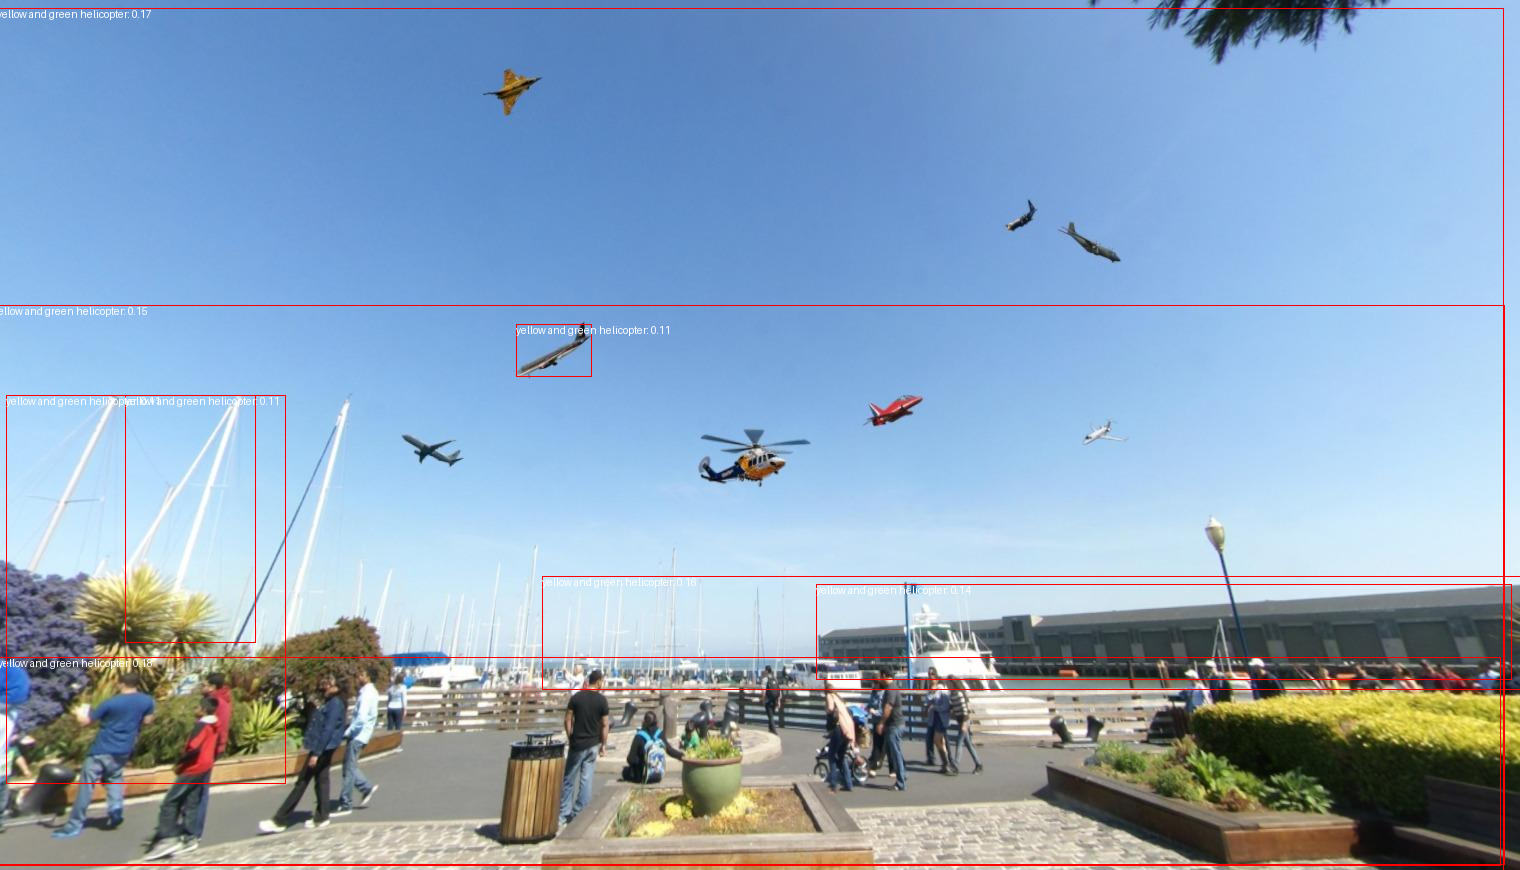

In [ ]:
model_path = "local/custom_owl_vit_1"
detector = pipeline(model=model_path, task="zero-shot-object-detection")

image = cppe5["train"][16]["image"]

predictions = detector(
    image,
    candidate_labels=categories,
    threshold=0.10,
    top_k=8
)
print(predictions)

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

image